In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'/home/bradhakrishnan/ECE276A_PR1/code/')

In [11]:
import motion_calibration
import load_data
import jax
import jax.numpy as jnp
import quaternion_ops as qops 
import numpy as np
dataset_idx= 9
jax.config.update("jax_enable_x64", True)


In [12]:
from load_data import load_dataset

In [13]:
imud,vicd, cam=load_dataset(dataset_idx)

Data import took: 3.192636728286743 sec.



In [14]:
cam_ts_2_vicd_ts_idx = {}
for cam_ts in cam['ts'][0]:
    temp = np.abs(vicd['ts'][0] - cam_ts)
    idx = np.argmin(temp)
    cam_ts_2_vicd_ts_idx[cam_ts] = idx

In [7]:
len(cam_ts_2_vicd_ts_idx)

1259

In [36]:
img_h, img_w, vert_angle_lim, hor_angle_lim= 240,320,45.0,60.0
W_pan=1800
H_pan=900
y_angles, x_angles = np.linspace(90-(vert_angle_lim/2), 90+(vert_angle_lim/2)-1, int(
    img_h))*np.pi/180 , np.linspace(90-(hor_angle_lim/2), 90+(hor_angle_lim/2)-1, int(img_w))*np.pi/180

In [35]:
lambda_grid, phi_grid = np.meshgrid(x_angles, y_angles)
#lets say depth is 2
r=1
X = r*np.cos(phi_grid) * np.cos(lambda_grid)
Y = r*np.cos(phi_grid) * np.sin(lambda_grid)
Z = r*np.sin(phi_grid)

In [64]:
phi_grid.shape

(240, 320)

In [36]:


R=vicd['rots'][:, :, cam_ts_2_vicd_ts_idx[1296636785.221946]]

In [37]:
# Stack coordinates and rotate into the world frame
coords = np.stack([X, Y, Z], axis=-1)  # Shape (H, W, 3)
coords_world = coords @ R.T  # Apply rotation

In [38]:
coords_world.shape

(240, 320, 3)

In [49]:
# Convert world coordinates to spherical coordinates
r = np.sqrt(coords_world[..., 0]**2 + coords_world[..., 1]**2)
lambda_world = np.arctan2(coords_world[..., 1], coords_world[..., 0])
phi_world = np.arctan2(coords_world[..., 2], r)

# Convert to cylindrical panorama coordinates
x_pan = ((lambda_world + np.pi) / (2 * np.pi) * W_pan).astype(int)
y_pan = ((phi_world + (np.pi / 2)) / np.pi * H_pan).astype(int)

# Create the panorama canvas
panorama = np.zeros((H_pan, W_pan, 3), dtype=np.uint8)

# Map image pixels to the panorama
panorama[y_pan, x_pan] = image

In [48]:
image= cam['cam'][:,:,:,]

image.reshape(-1, 3).shape

(76800, 3)

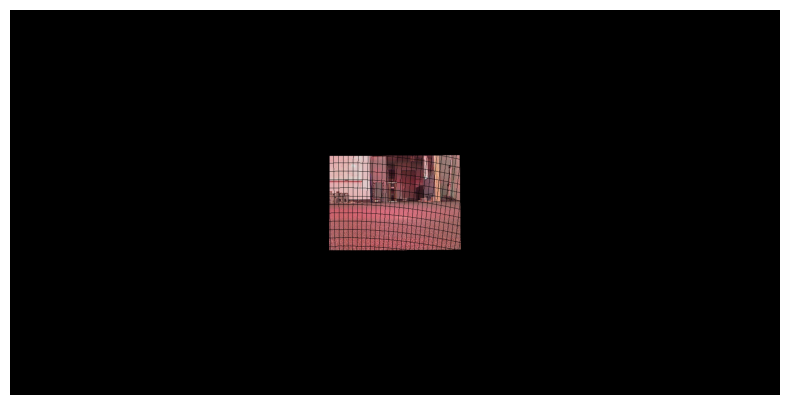

In [50]:
import cv2
import matplotlib.pyplot as plt


# Display using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(panorama)
plt.axis("off")  # Hide axis
plt.show()

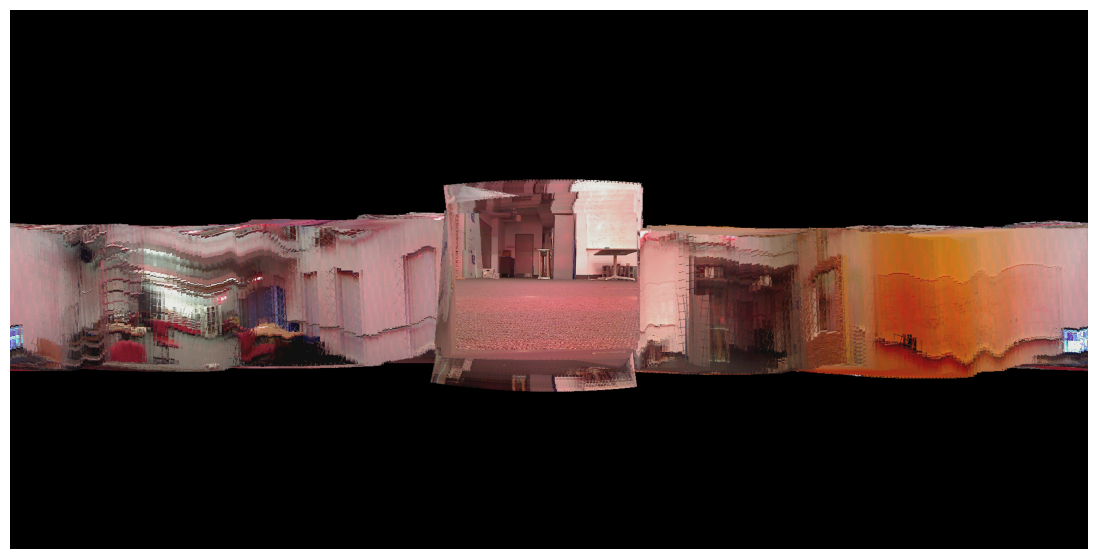

In [17]:
import numpy as np
import cv2

def project_to_panorama(image, R, W_pan=1960, H_pan=960, fov_x=60, fov_y=45):
    """
    Projects an image onto a panoramic cylindrical map given a camera rotation matrix R.
    """
    H, W, _ = image.shape

    # Convert FOV to radians
    fov_x_rad = np.radians(fov_x)
    fov_y_rad = np.radians(fov_y)

    # Generate longitude (λ) and latitude (φ) for each pixel
    x = np.linspace(-0.5, 0.5, W) * fov_x_rad  # Longitude
    y = np.linspace(-0.5, 0.5, H) * fov_y_rad  # Latitude (flip vertically)

    lambda_grid, phi_grid = np.meshgrid(x, y)

    # Convert to Cartesian coordinates (Assuming depth = 1)
    X = np.cos(phi_grid) * np.cos(lambda_grid)
    Y = np.cos(phi_grid) * np.sin(lambda_grid)
    Z = np.sin(phi_grid)

    # Stack coordinates and rotate into the world frame
    coords = np.stack([X, Y, Z], axis=-1)  # Shape (H, W, 3)
    coords_world = coords @ R.T  # Apply rotation

    # Convert world coordinates to spherical coordinates
    r = np.sqrt(coords_world[..., 0]**2 + coords_world[..., 1]**2)
    lambda_world = np.arctan2(coords_world[..., 1], coords_world[..., 0])
    phi_world = np.arctan2(coords_world[..., 2], r)

    # Convert to cylindrical panorama coordinates
    x_pan = ((lambda_world + np.pi) / (2 * np.pi) * W_pan).astype(int)
    y_pan = ((phi_world + (np.pi / 2)) / np.pi * H_pan).astype(int)

    # Create an empty canvas if it does not exist
    panorama = np.zeros((H_pan, W_pan, 3), dtype=np.uint8)

    # Map image pixels to the panorama
    valid_idx = (y_pan >= 0) & (y_pan < H_pan) & (x_pan >= 0) & (x_pan < W_pan)
    # Flatten arrays to avoid shape mismatches
    x_pan_flat = x_pan.ravel()[valid_idx.ravel()]
    y_pan_flat = y_pan.ravel()[valid_idx.ravel()]
    image_flat = image.reshape(-1, 3)[valid_idx.ravel()]

    # Assign pixels to the panorama
    panorama[y_pan_flat, x_pan_flat] = image_flat

    return panorama

def merge_images(image_list, R_list, W_pan=2048, H_pan=1024):
    """
    Merges multiple images into a panoramic view based on their corresponding rotations.
    """
    # Initialize the panorama canvas
    final_panorama = np.zeros((H_pan, W_pan, 3), dtype=np.uint8)

    for image, R in zip(image_list, R_list):
        projected = project_to_panorama(image, R, W_pan, H_pan)

        # Blend images (simple overwriting for now)
        mask = projected > 0  # Consider only non-black pixels
        final_panorama[mask] = projected[mask]

    return final_panorama  # Returns the merged panorama as an array

# Example Usage
# Assuming `images` is a list of NumPy arrays (H, W, 3) and `R_matrices` is a list of rotation matrices
panorama = merge_images(images, R_matrices)

# View in Jupyter Notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.imshow(panorama)
plt.axis("off")
plt.show()


In [16]:
images=[cam['cam'][:,:,:,i] for i in range(cam['cam'].shape[-1])]
R_matrices= [vicd['rots'][:, :, cam_ts_2_vicd_ts_idx[key]] for key in cam_ts_2_vicd_ts_idx.keys()]

1685

In [13]:
from tqdm import tqdm
def create_panorama(vicd, camd, fast):
    cam_time_map = {}
    HEIGHT, WIDTH = 960, 1920
    for t in camd['ts'][0]:
        temp = np.abs(vicd['ts'][0] - t)
        index = np.argmin(temp)
        cam_time_map[t] = index

    H, W, vert, hor = 240, 320, 45., 60.
    z_angles, x_angles = np.linspace(90-(vert/2), 90+(vert/2)-1, int(
        H)) * np.pi/180, np.linspace(90-(hor/2), 90+(hor/2)-1, int(W))*np.pi/180
    cartesian_temp, cartesian = np.ones((H, W, 4)), np.ones((H, W, 3))
    for i in range(z_angles.shape[0]):
        cartesian_temp[i, :, 0] = np.cos(x_angles)
    for i in range(x_angles.shape[0]):
        cartesian_temp[:, i, 1] = np.cos(z_angles)
    for i in range(z_angles.shape[0]):
        cartesian_temp[i, :, 2] = np.sin(x_angles)
    for i in range(x_angles.shape[0]):
        cartesian_temp[:, i, 3] = np.sin(z_angles)

    cartesian[:, :, 0] = np.multiply(
        cartesian_temp[:, :, 3], cartesian_temp[:, :, 0])
    cartesian[:, :, 1] = np.multiply(
        cartesian_temp[:, :, 3], cartesian_temp[:, :, 2])
    cartesian[:, :, 2] = cartesian_temp[:, :, 1]
    print('Created cartesian coordinates map')

    world_frame_cartesian = np.zeros((240, 320, 3, len(cam_time_map.keys())))
    for i in range(camd['cam'].shape[3]):
        world_frame_cartesian[:, :, :, i] = np.dot(
            cartesian, vicd['rots'][:, :, cam_time_map[camd['ts'][0][i]]])
    print('Created world frame')
    del cartesian_temp, cartesian, z_angles, x_angles, cam_time_map

    spherical_from_cartesian = np.zeros((H, W, 3, camd['cam'].shape[3]))

    spherical_from_cartesian_r = np.linalg.norm(world_frame_cartesian, axis=2)
    spherical_from_cartesian[:, :, 0,
                             :] = spherical_from_cartesian_r  # rho => z
    spherical_from_cartesian[:, :, 1, :] = np.arctan2(
        world_frame_cartesian[:, :, 1, :], world_frame_cartesian[:, :, 0, :])  # theta => x
    spherical_from_cartesian[:, :, 2, :] = np.arccos(
        world_frame_cartesian[:, :, 2, :]/spherical_from_cartesian_r)  # phi => y
    del spherical_from_cartesian_r

    sx, sy = (2*np.pi/WIDTH), (np.pi/HEIGHT)
    spherical_from_cartesian[:, :, 1, :] += np.pi
    spherical_from_cartesian[:, :, 1, :] /= sx
    spherical_from_cartesian[:, :, 2, :] /= sy
    spherical_from_cartesian[:, :, 2,
                             :] -= np.min(spherical_from_cartesian[:, :, 2, :])
    spherical_from_cartesian[:, :, 1,
                             :] -= np.min(spherical_from_cartesian[:, :, 1, :])
    spherical_from_cartesian = spherical_from_cartesian.astype(np.int32)
    print('Created spherical projection map\nCreating image:')

    image = np.zeros((HEIGHT, WIDTH, 3)).astype(np.int32)
    for r in tqdm(range(0, camd['cam'].shape[3], 30 if fast else 1)):
        for i in range(camd['cam'].shape[0]):
            for j in range(camd['cam'].shape[1]):
                _, x, y = spherical_from_cartesian[i, j, :, r]
                image[y, x, :] = camd['cam'][i, j, :, r]
    print('Image created')
    return image

Created cartesian coordinates map
Created world frame
Created spherical projection map
Creating image:


100%|██████████| 860/860 [01:39<00:00,  8.68it/s]

Image created


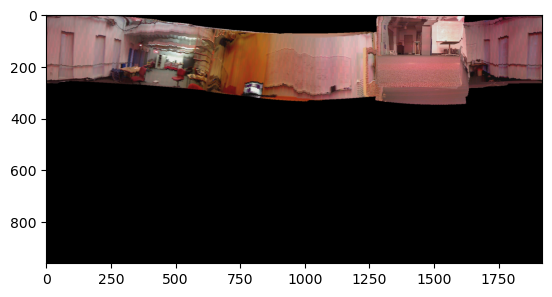

In [14]:
import matplotlib.pyplot as plt

plt.imshow(create_panorama(vicd, cam,False))
# p=(create_panorama(vicd, cam,False))


In [33]:
import numpy as np
from tqdm import tqdm

def create_panorama_optimized(vicd, camd, fast=False):
    """
    Generates a panoramic image from multiple camera images and their corresponding rotations.
    
    Parameters:
    vicd : dict
        Contains 'ts' (timestamps) and 'rots' (rotation matrices).
    camd : dict
        Contains 'ts' (timestamps) and 'cam' (camera images).
    fast : bool, optional
        If True, skips frames to accelerate processing.

    Returns:
    np.ndarray
        The generated panoramic image.
    """

    HEIGHT, WIDTH = 960, 1920  # Output panorama dimensions
    H, W = 240, 320  # Input image dimensions
    vert_fov, hor_fov = 45., 60.  # Field of view

    # Precompute angle grids
    z_angles = np.radians(np.linspace(90 - vert_fov / 2, 90 + vert_fov / 2 - 1, H))
    x_angles = np.radians(np.linspace(90 - hor_fov / 2, 90 + hor_fov / 2 - 1, W))

    # Generate Cartesian coordinates (camera frame)
    X = np.outer(np.cos(z_angles), np.cos(x_angles))
    Y = np.outer(np.ones_like(z_angles), np.sin(x_angles))
    Z = np.outer(np.sin(z_angles), np.ones_like(x_angles))

    cartesian = np.stack([X, Y, Z], axis=-1)  # Shape: (H, W, 3)

    # Map camera timestamps to closest vehicle timestamps
    cam_time_map = {t: np.argmin(np.abs(vicd['ts'][0] - t)) for t in camd['ts'][0]}

    # Transform to world coordinates
    num_frames = len(cam_time_map)
    world_coords = np.einsum('ijk,klm->ijlm', cartesian, vicd['rots'][:, :, list(cam_time_map.values())])

    # Convert to spherical coordinates
    rho = np.linalg.norm(world_coords, axis=2)
    theta = np.arctan2(world_coords[:, :, 1, :], world_coords[:, :, 0, :]) + np.pi  # Normalize to [0, 2π]
    phi = np.arccos(world_coords[:, :, 2, :] / rho)

    # Normalize to image coordinates
    x_mapped = (theta / (2 * np.pi) * WIDTH).astype(int)
    y_mapped = (phi / np.pi * HEIGHT).astype(int)

    # Create panorama
    panorama = np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8)

    # Fill the panorama with images
    step = 30 if fast else 1  # Skip frames if fast mode is enabled
    for r in tqdm(range(0, num_frames, step)):
        valid_x = (x_mapped[:, :, r] >= 0) & (x_mapped[:, :, r] < WIDTH)
        valid_y = (y_mapped[:, :, r] >= 0) & (y_mapped[:, :, r] < HEIGHT)

        valid_pixels = valid_x & valid_y
        x_valid = x_mapped[:, :, r][valid_pixels]
        y_valid = y_mapped[:, :, r][valid_pixels]
        colors = camd['cam'][..., r].reshape(H * W, 3)[valid_pixels.flatten()]

        panorama[y_valid, x_valid] = colors  # Assign colors efficiently

    return panorama


100%|██████████| 1259/1259 [00:04<00:00, 282.38it/s]


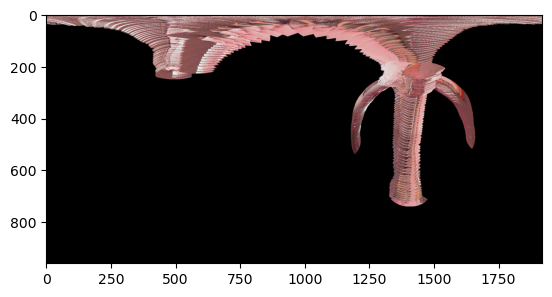

In [35]:
import matplotlib.pyplot as plt

plt.imshow(create_panorama_optimized(vicd, cam,False))